In [2]:
import pandas as pd; pd.set_option('display.max_columns',100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

from matplotlib import pyplot as plt; plt.style.use('ggplot')
import seaborn as sns  
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline,Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import optuna

In [3]:
original=pd.read_csv("Churn_Modelling.csv")
sample_sub=pd.read_csv("sample_submission.csv")
test=pd.read_csv("test.csv")
train=pd.read_csv("train.csv")

In [4]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
CustomerId,15674932,15749177,15694510,15741417,15766172
Surname,Okwudilichukwu,Okwudiliolisa,Hsueh,Kao,Chiemenam
CreditScore,668,627,678,581,716
Geography,France,France,France,France,Spain
Gender,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0
Tenure,3,1,10,2,5
Balance,0.0,0.0,0.0,148882.54,0.0
NumOfProducts,2,2,2,1,2


In [5]:
num_train=train.select_dtypes(include=['int','float'])
num_train.drop(columns=['Exited','Tenure','id','CustomerId','NumOfProducts','HasCrCard','IsActiveMember'],axis=1,inplace=True)
num_train.head()

,CreditScore,Age,Balance,EstimatedSalary
0,668,33.0,0.00,181449.97
1,627,33.0,0.00,49503.50
2,678,40.0,0.00,184866.69
3,581,34.0,148882.54,84560.88
4,716,33.0,0.00,15068.83


### Visualize Distribution of Numerical data

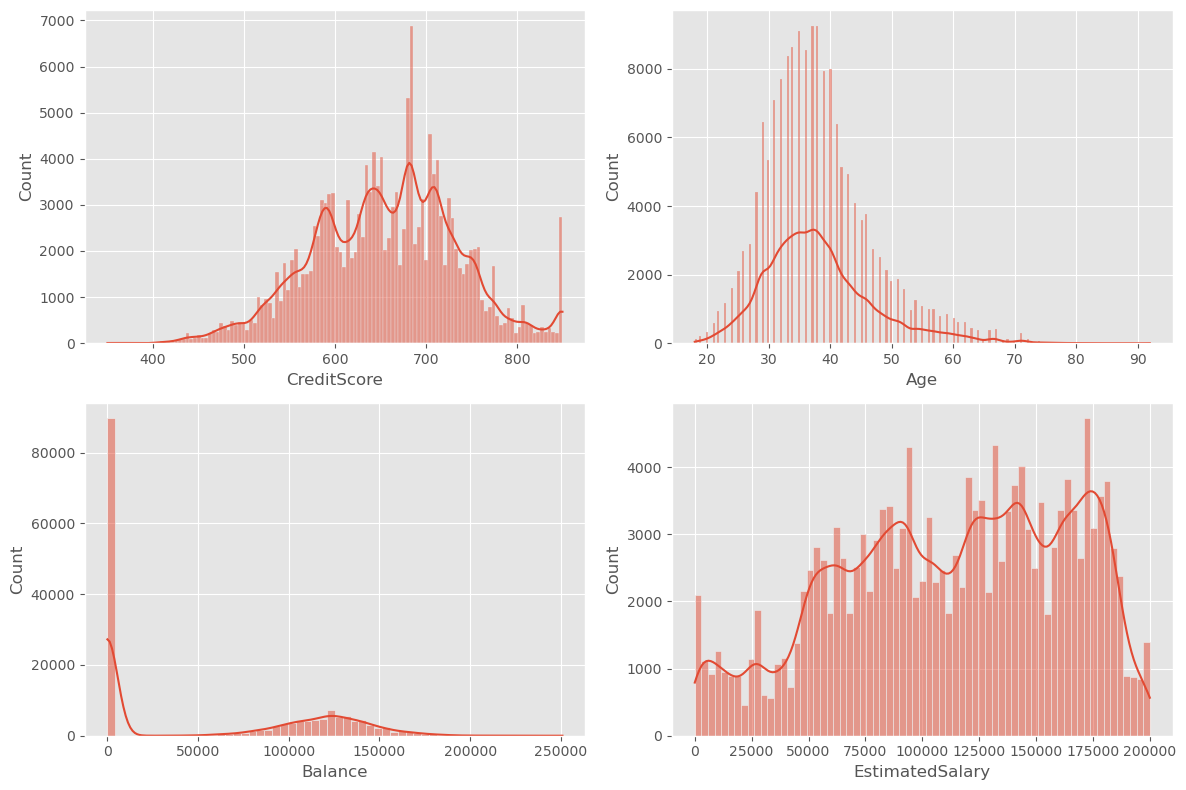

In [6]:
rows=(len(num_train.columns)+1)//2

fig,axes=plt.subplots(rows,2,figsize=(12,rows*4))
for i,col in enumerate(num_train.columns):
    sns.histplot(data=num_train[col],kde=True,ax=axes[i//2,i%2])

plt.tight_layout()

### Visualize Distribution of Categorical Data

In [7]:
cat_train=train.select_dtypes(include=['object'])
cat_train=pd.concat([cat_train,train[['Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']]],axis=1)
cat_train.drop(columns=['Surname'],axis=1,inplace=True)
cat_train.head()

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,France,Male,3,2,1.0,0.0,0
1,France,Male,1,2,1.0,1.0,0
2,France,Male,10,2,1.0,0.0,0
3,France,Male,2,1,1.0,1.0,0
4,Spain,Male,5,2,1.0,1.0,0


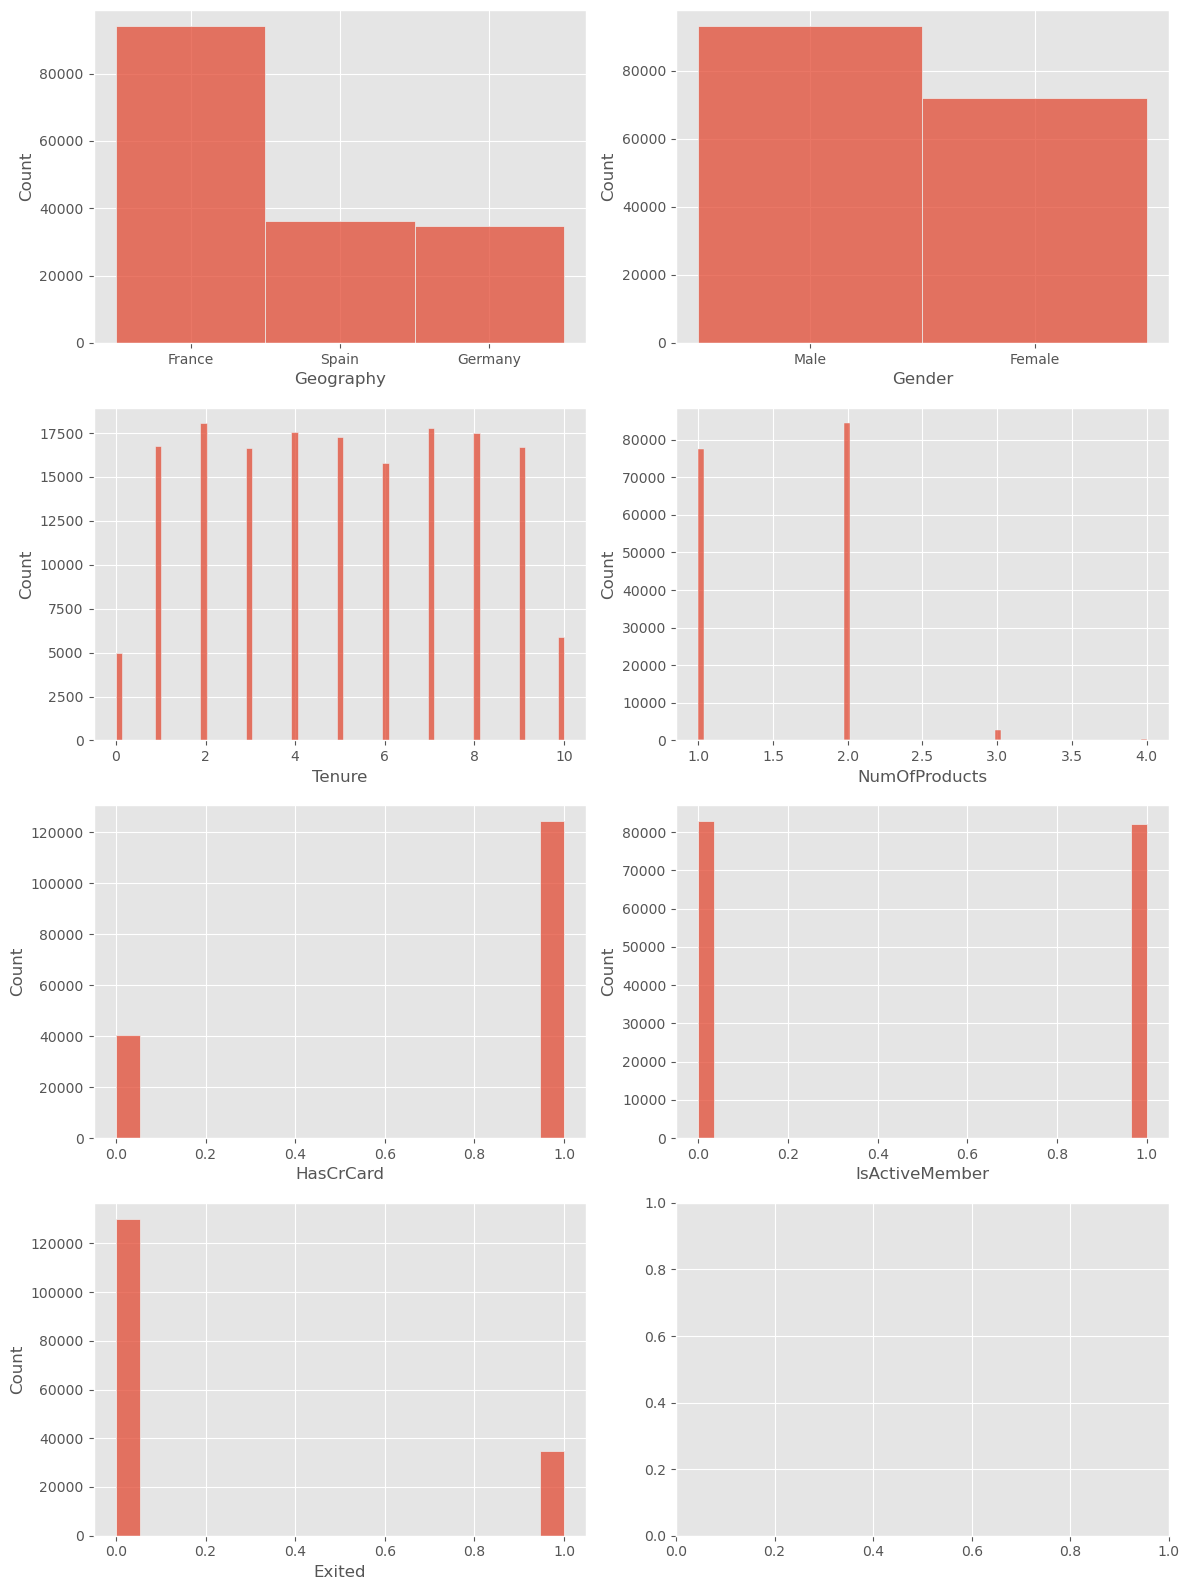

In [8]:
fig,axes=plt.subplots((len(cat_train.columns)+1)//2,2,figsize=(12,(len(cat_train.columns)+1)//2*4))
for i,col in enumerate(cat_train.columns):
    sns.histplot(data=cat_train[col],ax=axes[i//2,i%2])

plt.tight_layout()

In [9]:
train_data=train.copy(deep=True)
train_data=pd.concat([train_data,original],axis=0)
train_data.drop(columns=['RowNumber'],axis=1,inplace=True)
train_data.drop(columns=['id','CustomerId','Surname'],axis=1,inplace=True)

In [10]:

train_data.head().T

,0,1,2,3,4
CreditScore,668,627,678,581,716
Geography,France,France,France,France,Spain
Gender,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0
Tenure,3,1,10,2,5
Balance,0.0,0.0,0.0,148882.54,0.0
NumOfProducts,2,2,2,1,2
HasCrCard,1.0,1.0,1.0,1.0,1.0
IsActiveMember,0.0,1.0,0.0,1.0,1.0
EstimatedSalary,181449.97,49503.5,184866.69,84560.88,15068.83


In [11]:
train_data["Gender"]=train_data["Gender"].map({'Female':0,'Male':1})
train_data.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CreditScore,668,627,678,581,716,588,593,678,676,583,599,687,759,681,703,549,602,636,645,559
Geography,France,France,France,France,Spain,Germany,France,Spain,France,Germany,Germany,Germany,Spain,France,France,France,France,France,Germany,France
Gender,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,0,1,1,0,1
Age,33.0,33.0,40.0,34.0,33.0,36.0,30.0,37.0,43.0,40.0,27.0,40.0,71.0,47.0,33.0,25.0,36.0,36.0,55.0,61.0
Tenure,3,1,10,2,5,4,8,1,4,4,6,3,9,5,7,5,7,4,8,1
Balance,0.0,0.0,0.0,148882.54,0.0,131778.58,144772.69,138476.41,0.0,81274.33,161801.47,90432.92,0.0,0.0,190566.65,0.0,0.0,117559.05,120105.43,153711.26
NumOfProducts,2,2,2,1,2,1,1,1,2,1,2,1,1,1,1,2,2,2,1,1
HasCrCard,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
IsActiveMember,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
EstimatedSalary,181449.97,49503.5,184866.69,84560.88,15068.83,136024.31,29792.11,106851.6,142917.13,170843.07,109184.24,1676.92,93081.87,72945.68,79997.14,162260.93,135082.47,111573.3,125083.29,180890.4


In [12]:
train_data=pd.concat([train_data,pd.get_dummies(train_data["Geography"],drop_first=True)],axis=1)
train_data.drop(columns=['Geography'],axis=1,inplace=True)

In [13]:
imputer=KNNImputer(n_neighbors=3)
train_data=pd.DataFrame(imputer.fit_transform(train_data),columns=train_data.columns)
train_data.head().T

,0,1,2,3,4
CreditScore,668.00,627.0,678.00,581.00,716.00
Gender,1.00,1.0,1.00,1.00,1.00
Age,33.00,33.0,40.00,34.00,33.00
Tenure,3.00,1.0,10.00,2.00,5.00
Balance,0.00,0.0,0.00,148882.54,0.00
NumOfProducts,2.00,2.0,2.00,1.00,2.00
HasCrCard,1.00,1.0,1.00,1.00,1.00
IsActiveMember,0.00,1.0,0.00,1.00,1.00
EstimatedSalary,181449.97,49503.5,184866.69,84560.88,15068.83
Exited,0.00,0.0,0.00,0.00,0.00


In [14]:
X=train_data.drop(columns=['Exited'],axis=1)
y=train_data['Exited']

In [15]:
from xgboost import XGBClassifier

def objective(trial):
    params={'n_estimators':trial.suggest_int('n_estimators',100,1000),
            'max_depth':trial.suggest_int('max_depth',3,40),
            'min_child_weight':trial.suggest_float('min_child_weight',2,50),
            'learning_rate':trial.suggest_float('learning_rate',1e-4,0.3,log=True),
            'subsample':trial.suggest_float('subsample',0.2,1),
            'gamma':trial.suggest_float("gamma",1e-4,1.0),
            'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1),
            'colsample_bylevel':trial.suggest_float('colsample_bylevel',0.2,1),
            'colsample_bynode':trial.suggest_float('colsample_bynode',0.2,1),
            'reg_alpha':trial.suggest_float('reg_alpha',1e-4,1),
            'reg_lambda':trial.suggest_float('reg_lambda',1e-4,1)
            }
    xgb_optuna=XGBClassifier(**params,random_state=42)
    cv=cross_val_score(xgb_optuna,X,y,scoring='roc_auc',n_jobs=-1,cv=10).mean()
    return cv

    
    


In [16]:
# %%time 
# study=optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=20)
# study.best_params

In [17]:
train_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,668.0,1.0,33.0,3.0,0.00,2.0,1.0,0.0,181449.97,0.0,0.0,0.0
1,627.0,1.0,33.0,1.0,0.00,2.0,1.0,1.0,49503.50,0.0,0.0,0.0
2,678.0,1.0,40.0,10.0,0.00,2.0,1.0,0.0,184866.69,0.0,0.0,0.0
3,581.0,1.0,34.0,2.0,148882.54,1.0,1.0,1.0,84560.88,0.0,0.0,0.0
4,716.0,1.0,33.0,5.0,0.00,2.0,1.0,1.0,15068.83,0.0,0.0,1.0


In [18]:
test_data=test.copy(deep=True)
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [19]:
test_data.drop(columns=['id','CustomerId','Surname'],axis=1,inplace=True)
test_data=pd.concat([test_data,pd.get_dummies(test_data["Geography"],drop_first=True)],axis=1)
test_data.drop(columns=['Geography'],axis=1,inplace=True)
test_data["Gender"]=test_data["Gender"].map({'Female':0,'Male':1})

In [20]:
test_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain
0,586,0,23.0,2,0.00,2,0.0,1.0,160976.75,0,0
1,683,0,46.0,2,0.00,1,1.0,0.0,72549.27,0,0
2,656,0,34.0,7,0.00,2,1.0,0.0,138882.09,0,0
3,681,1,36.0,8,0.00,1,1.0,0.0,113931.57,0,0
4,752,1,38.0,10,121263.62,1,1.0,0.0,139431.00,1,0


In [21]:
# params={'n_estimators': 996,
#  'max_depth': 10,
#  'min_child_weight': 16.016066150633964,
#  'learning_rate': 0.009999277108189502,
#  'subsample': 0.8619913758887425,
#  'gamma': 0.34134926742640626,
#  'colsample_bytree': 0.6180310829382322,
#  'colsample_bylevel': 0.713237327858907,
#  'colsample_bynode': 0.6183914852849193,
#  'reg_alpha': 0.6404183775859038,
#  'reg_lambda': 0.567229021882353}

params={'n_estimators': 1733, 'max_depth': 36, 'min_child_weight': 2.0816321425761783, 'learning_rate': 0.033906252376247406, 'subsample': 0.7307948591331253, 'gamma': 0.4357664926361755, 'colsample_bytree': 0.6220692048723626, 'colsample_bylevel': 0.2895540629386588, 'colsample_bynode': 0.9932504880638549, 'reg_alpha': 0.3876038008629634, 'reg_lambda': 0.08948140893044246}

model=XGBClassifier(**params,random_state=42)
inf_model=model.fit(X,y)
# pred=inf_model.predict_proba(test_data)[:]

In [22]:
inf_model.predict_proba(test_data)

array([[0.96793574, 0.03206425],
       [0.16723704, 0.83276296],
       [0.9758842 , 0.02411577],
       ...,
       [0.97962356, 0.02037643],
       [0.83587813, 0.16412185],
       [0.8426113 , 0.1573887 ]], dtype=float32)

In [23]:
y_pred=inf_model.predict_proba(test_data)[:,1]


In [24]:
# sample_sub.head()

In [25]:
# sample_sub['Exited']=y_pred
# sample_sub.to_csv('submission3.csv',index=False)

In [28]:
lgbm_model=LGBMClassifier(random_state=42)

cross_val_score(lgbm_model,X,y,scoring='roc_auc',n_jobs=-1,cv=RepeatedStratifiedKFold(n_splits=7,n_repeats=6,random_state=42)).mean()

0.8883155758445265

In [29]:
cross_val_score(CatBoostClassifier(random_state=42),X,y,scoring='roc_auc',n_jobs=-1,cv=RepeatedStratifiedKFold(n_splits=7,n_repeats=6,random_state=42)).mean()